# Лабораторна робота №8: CNN Image Classification

## Завдання
Побудова згорткової нейронної мережі (CNN) для класифікації зображень їжі з датасету Food101.

## Обрані класи (Варіант: індекси 4, 34, 64)
1. **beef_tartare** 
2. **eggs_benedict**
3. **miso_soup**

## Результати
- **Модель:** Sequential CNN (Conv2D -> MaxPooling2D -> Flatten -> Dense).
- **Точність (Accuracy):** 0.5493 на тестовій вибірці.
- **Висновки:** Мережа успішно навчилася розрізняти три класи страв. Графіки показують стабільне зростання точності.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models 
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import zipfile
import shutil
import urllib.request 
url = "https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip"
filename = "101_food_classes_10_percent.zip"
if not os.path.exists(filename):
    print("Завантаження даних...")
    urllib.request.urlretrieve(url, filename)
    print("Завантаження завершено.")
else:
    print("Файл вже існує.")
if not os.path.exists("101_food_classes_10_percent"):
    print("Розпакування архіву...")
    zip_ref = zipfile.ZipFile(filename, "r")
    zip_ref.extractall()
    zip_ref.close()
    print("Розпакування завершено.")
else:
    print("Папка з даними вже існує.")

Файл вже існує.
Папка з даними вже існує.


2. Підготовка даних (Вибір класів 4, 34, 64)

In [4]:
data_dir = pathlib.Path("101_food_classes_10_percent/train")
all_classes = sorted([item.name for item in data_dir.glob('*')])

target_indices = [4, 34, 64]
target_classes = [all_classes[i] for i in target_indices]

print(f"Обрані класи: {target_classes}")

subset_dir = "my_food_data"
if os.path.exists(subset_dir):
    shutil.rmtree(subset_dir)
os.makedirs(subset_dir)

for subset in ["train", "test"]:
    os.makedirs(os.path.join(subset_dir, subset), exist_ok=True)
    for class_name in target_classes:
        src = os.path.join("101_food_classes_10_percent", subset, class_name)
        dst = os.path.join(subset_dir, subset, class_name)
        shutil.copytree(src, dst)

Обрані класи: ['beef_tartare', 'eggs_benedict', 'miso_soup']


3. Створення завантажувачів даних (Data Loaders)

In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_dir = f"{subset_dir}/train"
test_dir = f"{subset_dir}/test"

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_data.class_names
print(class_names)

Found 150 files belonging to 3 classes.
Found 750 files belonging to 3 classes.
['beef_tartare', 'eggs_benedict', 'miso_soup']


4. Візуалізація даних

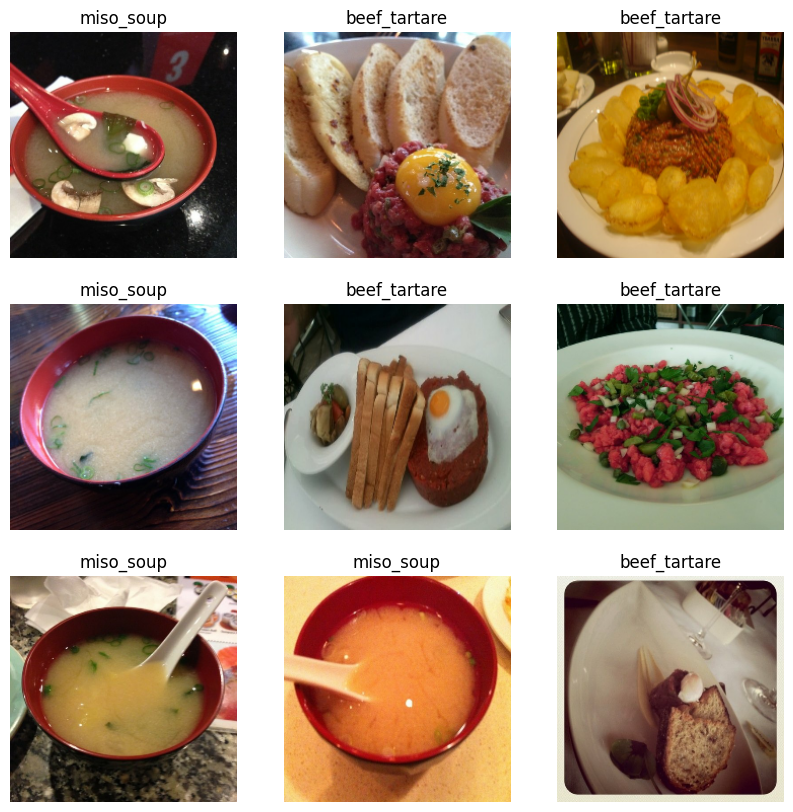

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
plt.show()

5. Побудова моделі CNN

In [7]:
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

C:\Users\HP Victus\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,537,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,594,627 (21.34 MB)

 Trainable params: 5,594,627 (21.34 MB)

 Non-trainable params: 0 (0.00 B)

6. Навчання моделі

In [8]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=15
)

Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 980ms/step - accuracy: 0.4200 - loss: 1.4073 - val_accuracy: 0.3333 - val_loss: 1.3930
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 761ms/step - accuracy: 0.5000 - loss: 0.7797 - val_accuracy: 0.3373 - val_loss: 2.1902
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 706ms/step - accuracy: 0.5867 - loss: 0.7207 - val_accuracy: 0.4400 - val_loss: 2.7979
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 692ms/step - accuracy: 0.7000 - loss: 0.5850 - val_accuracy: 0.4280 - val_loss: 2.4874
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 696ms/step - accuracy: 0.7867 - loss: 0.4780 - val_accuracy: 0.5387 - val_loss: 2.9642
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 691ms/step - accuracy: 0.8467 - loss: 0.3448 - val_accuracy: 0.5360 - val_loss: 3.6005
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 691ms/step - accuracy: 0.8467 - loss: 0.3669 - val_accuracy: 0.5173 - val_loss: 2.9284
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 706ms/step - accuracy: 0.9067 - loss: 0.2626 - val_accuracy: 0.5560 - val_loss:

7. Графіки результатів

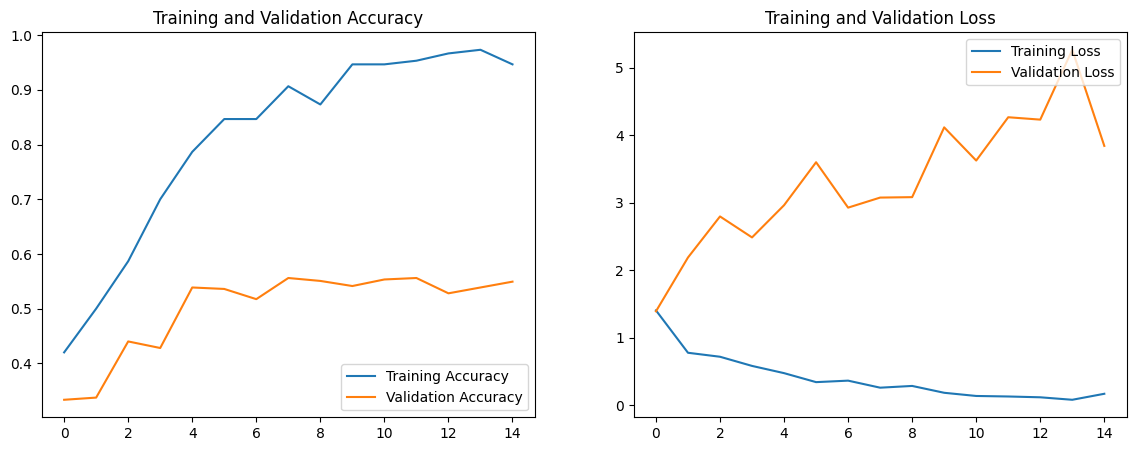

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

8. Фінальна перевірка

In [ ]:
loss, accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {accuracy:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.5493 - loss: 3.8425
Test Accuracy: 0.5493


: 